# Data Processes Assignment 2

EIT Digital Data Science: \
Davis Siemens \
Inés Simón del Collado \
Xiya Sun

## Content of notebook 

In this notebook we will preprocess the merged patient data. Steps include: 
1. Remove measuring errors for numerical attributes
2. Categorize and one-hot encode categorial attributes 
3. Label encode all binary variables 
4. 

In [89]:
# libraries
import pandas as pd
import pycountry 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [90]:
# Reading merged patient data
all_patients = pd.read_excel('./all_patients.xlsx', index_col=None)

### 1. Remove measuring errors for numerical attributes
- Replace all values in the `oxygen_saturation` column below 20 (the lowest ever recorded in a living human being) with `NaN`.
- In the EDA we already identified that temperature does not have any measuring errors.


In [91]:
oxygen_saturation_before_error_replacement = all_patients['oxygen_saturation'].describe()
#print(all_patients[all_patients['oxygen_saturation'] < 20])

# Replace oxygen saturation values below 20 with NaN. 20 is the lowest ever measure oxigen level on a living human being. 
all_patients['oxygen_saturation'] = all_patients['oxygen_saturation'].apply(
    lambda x: np.nan if x < 20 else x
)

# Verify the changes
print("Oxygen Saturation before error replacement:")
print(oxygen_saturation_before_error_replacement)
print("Oxygen Saturation after error replacement:")
print(all_patients['oxygen_saturation'].describe())
print()
print(all_patients['oxygen_saturation'].isnull().sum(), "values replaced with NaN")

Oxygen Saturation before error replacement:
count    27438.000000
mean        93.625519
std          8.020814
min         -1.000000
25%         94.000000
50%         95.000000
75%         96.000000
max        100.000000
Name: oxygen_saturation, dtype: float64
Oxygen Saturation after error replacement:
count    27295.000000
mean        94.117201
std          4.275768
min         26.000000
25%         94.000000
50%         95.000000
75%         96.000000
max        100.000000
Name: oxygen_saturation, dtype: float64

154 values replaced with NaN


### 2. Remove rows and columns with excessive missing values

- Before the NaN replacements we will remove columns and rows with mostly missing values
- We identify two rows in the dataset where more than 50% of the values are missing (`NaN`) and remove them. 
- We cannot indentify any columns with more than 30% missing data. Therefore we remove none.


In [98]:
# Check for rows with more than 50% NaN values
threshold = all_patients.shape[1] / 2  # Calculate the threshold for NaN count
rows_with_many_nans = all_patients[all_patients.isnull().sum(axis=1) > threshold]

# Print the rows that will be dropped (for debugging or logging purposes)
print(f"Rows with more than 50% NaN values (count: {len(rows_with_many_nans)}):")
print(rows_with_many_nans)

# Drop rows with more than 50% NaN values
all_patients = all_patients[all_patients.isnull().sum(axis=1) <= threshold]

# Verify the change
print(f"Dataset after removing rows with more than 50% NaN values (remaining rows: {all_patients.shape[0]}).")

# Check for columns with more than 30% missing data
threshold_col = 0.3 * all_patients.shape[0]  # Threshold for columns with excessive NaNs
columns_with_many_nans = all_patients.columns[all_patients.isnull().sum() > threshold_col]

# Print the columns with excessive missing data
if len(columns_with_many_nans) > 0:
    print(f"Columns with more than 30% missing data (count: {len(columns_with_many_nans)}):")
    print(columns_with_many_nans)
else:
    print("No columns have more than 30% missing data.")

Rows with more than 50% NaN values (count: 0):
Empty DataFrame
Columns: [ID, abdominal_pain, age, aids_hiv, altered_consciousness_confusion, anorexia, asplenia, asthma, bleeding, chest_pain, chronic_cardiac_disease, chronic_hematologic_disease, chronic_kidney_disease, chronic_neurological_disorder, chronic_pulmonary_disease, conjunctivitis, cough, dementia, diabetes_mellitus_type_1, diabetes_mellitus_type_2, diarrhoea, fatigue_malaise, fever_temperature, gender, headache, history_of_fever, hypertension, inability_to_walk, joint_pain, liver_disease, loss_of_smell, loss_of_taste, lower_chest_wall_indrawing, lymphadenopathy, malignant_neoplasm, muscle_aches, obesity, other_risks, other_symptoms, oxygen_saturation, pcr_result, rheumatologic_disorder, runny_nose, shortness_of_breath, skin_rash, smoking, sore_throat, tuberculosis, vomiting_nausea, wheezing, is_turkey, month_1.0, month_2.0, month_3.0, month_4.0, month_5.0, month_6.0, month_7.0, month_8.0, month_9.0, month_10.0, month_11.0, mo

### 3. Label encode all binary variables 
Use the LabelEncoder to encode all binary variables. PCR result and gender are considered a binary variable. 

1. **Replace Invalid Values**:
   - For binary columns, any values that do not fit the binary scheme (e.g., `E=Men`, `F=Women`) are replaced with `NaN`.

2. **Impute Missing Values**:
   - Missing values (`NaN`) in the binary columns are replaced based on the dominant value or feature distribution:
     - **`pcr_result`**: Since this feature is dominantly `positive (1)`, missing values are imputed with `1`.
     - **`gender`**: This feature has a balanced distribution. Missing values are imputed with the mode of the column.
     - **All other binary features**: These features are dominantly `0`, so missing values are imputed with `0`.

3. **Apply Label Encoding**:
   - After handling missing values, each binary column is encoded using `LabelEncoder` to transform the values into integers (`0` and `1`).
   - The encoders are stored in a dictionary (`label_encoders`) for potential inverse transformation or reuse.

4. **Debugging and Verification**:
   - A list of non-binary columns is printed to ensure the dataset is correctly preprocessed.
   - The first few rows of the transformed dataset are displayed for verification.

In [93]:
# List of binary columns
binary_columns = [
    'abdominal_pain', 'aids_hiv', 'altered_consciousness_confusion', 'anorexia', 
    'asplenia', 'asthma', 'bleeding', 'chest_pain', 'chronic_cardiac_disease', 
    'chronic_hematologic_disease', 'chronic_kidney_disease', 'chronic_neurological_disorder', 
    'chronic_pulmonary_disease', 'conjunctivitis', 'cough', 'dementia', 
    'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2', 'diarrhoea', 'fatigue_malaise', 
    'headache', 'history_of_fever', 'hypertension', 'inability_to_walk', 'joint_pain', 
    'liver_disease', 'loss_of_smell', 'loss_of_taste', 'lower_chest_wall_indrawing', 
    'lymphadenopathy', 'malignant_neoplasm', 'muscle_aches', 'obesity', 'other_risks', 
    'other_symptoms', 'rheumatologic_disorder', 'runny_nose', 'shortness_of_breath', 
    'skin_rash', 'smoking', 'sore_throat', 'tuberculosis', 'vomiting_nausea', 'wheezing',
    'gender', 'pcr_result'  # Including gender and pcr_result as binary columns
]

# Debug: Identify non-binary columns
non_binary_columns = [col for col in all_patients.columns if col not in binary_columns]
print("Non-binary columns for debugging purposes:", non_binary_columns)

# Replace invalid values, encode, and impute null values
label_encoders = {}  # Dictionary to store encoders for future use

for col in binary_columns:
    if col == 'gender':
        # Map 'E' to 0, 'K' to 1, others to NaN
        all_patients[col] = all_patients[col].apply(lambda x: 0 if x == 'E' else 1 if x == 'K' else np.nan)
        # Impute missing values with the mode (balanced distribution)
        all_patients[col].fillna(all_patients[col].mode()[0], inplace=True)
    elif col == 'pcr_result':
        # Map 'negative' to 0, 'positive' to 1, others to NaN
        all_patients[col] = all_patients[col].apply(lambda x: 0 if x == 'negative' else 1 if x == 'positive' else np.nan)
        # Impute missing values with 1 (dominant positive distribution)
        all_patients[col].fillna(1, inplace=True)
    else:
        # Replace invalid binary values (not 0 or 1) with NaN
        all_patients[col] = all_patients[col].apply(lambda x: x if x in [0, 1] else np.nan)
        # Impute missing values with 0 (dominantly 0)
        all_patients[col].fillna(0, inplace=True)
    
    # Apply LabelEncoder to binary columns
    le = LabelEncoder()
    all_patients[col] = le.fit_transform(all_patients[col].astype(str))
    label_encoders[col] = le  # Save the encoder for future use

# Display the transformed data
print("Transformed binary columns with imputed values:")
print(all_patients[binary_columns].head())

Non-binary columns for debugging purposes: ['ID', 'age', 'date_of_first_symptoms', 'fever_temperature', 'nationality_country', 'oxygen_saturation']


/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/3898886306.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_patients[col].fillna(0, inplace=True)
/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/3898886306.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

Transformed binary columns with imputed values:
   abdominal_pain  aids_hiv  altered_consciousness_confusion  anorexia  \
0               0         0                                0         0   
1               0         0                                0         0   
2               0         0                                0         0   
3               0         0                                0         0   
4               0         0                                0         0   

   asplenia  asthma  bleeding  chest_pain  chronic_cardiac_disease  \
0         0       0         0           0                        0   
1         0       0         0           0                        0   
2         0       0         0           0                        0   
3         0       0         0           0                        0   
4         0       0         0           1                        0   

   chronic_hematologic_disease  ...  runny_nose  shortness_of_breath  \
0             

/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/3898886306.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_patients[col].fillna(0, inplace=True)
/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/3898886306.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

### 3. Unify, impute, analyze, and binary classify country/nationality values

- **3.1**: Standardize all values in the `nationality_country` column by mapping them to their three-digit country codes. 
  - Exception handling is implemented for non-standard or misspelled values, such as `"T.C."` (mapped to `"TUR"`), `"Chad (Tchad)"`, and `"Spain (EspaÃ±a)"`.

- **3.2**: Replace all `NaN` values in the `nationality_country` column with the code `"TUR"` (Turkey), as it is the most dominant class in the dataset. 

- **3.3**: Visualize the country distribution across the entire dataset to analyze distribution.

- **3.4**: Based on the analysis, we decide to binary encode the `nationality_country` feature as `"TUR=0"` and `"Non-TUR=1"`. 
  - This is due to the class imbalance (95% `"TUR"`) and the sparse representation of other countries (e.g., the second-largest class is represented only ~200 times).

#### 3.1. & 3.2: Standardize and Replace NAN

In [94]:

# Create a dictionary of valid country names and their codes
country_mapping = {country.name: country.alpha_3 for country in pycountry.countries}

# Add mappings for invalid names
custom_country_mapping = {
    "T.C.": "TUR",
    "Chad (Tchad)": "TCD",
    "Venezuela": "VEN",
    "United Kingdom (Great Britain)": "GBR",
    "Jordan (Hashemite Kingdom of Jordan)": "JOR",
    "Slovakia (Slovak Republic)": "SVK",
    "Iran (Islamic Republic of Iran)": "IRN",
    "USA": "USA",
    "Czech Republic": "CZE",
    "Kosova Cumhuriyeti": "KOS",
    "KUZEY KIBRIS TÃœRK CUM.": "CYP",
    "Bosnia And HerzegovÄ±na": "BIH",
    "Palestinian Territories": "PSE",
    "Libya (Libyan Arab Jamahirya)": "LBY",
    "Spain (EspaÃ±a)": "ESP",
    "Russia": "RUS",
    "Aland Islands": "ALA",
    "Macedonia (Former Yugoslav Republic of Macedonia)": "MKD",
    "Democratic Republic Of The Congo": "COD",
    "Saudi Arabia (Kingdom of Saudi Arabia)": "SAU",
    "DiÄŸer": np.nan,  # Not identifiable
    "The Turkish Republic Of Northern Cyprus": "CYP",
    "Tanzania": "TZA",
    "RÃ‰UNION": "REU",
    "CÃ”TE DIVOIRE (Ivory Coast)": "CIV",
    "Moldova": "MDA",
}

# Combine with pycountry mapping
country_mapping.update(custom_country_mapping)

# Replace invalid country names with their codes
def replace_with_country_code(country_name):
    if country_name in country_mapping:
        return country_mapping[country_name]
    else:
        print(f"Unmapped country name detected: {country_name}")
        return np.nan

# Apply the replacement to the nationality_country column
if 'nationality_country' in all_patients.columns:
    all_patients['nationality_country'] = all_patients['nationality_country'].apply(replace_with_country_code)
    print("Replaced invalid country names with country codes.")
    
    # Replace NaN values with 'TUR' (Turkey)
    all_patients['nationality_country'].fillna('TUR', inplace=True)
    print("Replaced all NaN values in 'nationality_country' with 'TUR'.")
else:
    print("'nationality_country' column not found in the dataset.")

# Display the first few rows to verify
print(all_patients['nationality_country'].head())

Unmapped country name detected: DiÄŸer 
Unmapped country name detected: nan
Unmapped country name detected: nan
Replaced invalid country names with country codes.
Replaced all NaN values in 'nationality_country' with 'TUR'.
0    TUR
1    TUR
2    TUR
3    TUR
4    TUR
Name: nationality_country, dtype: object


/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/1525000586.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_patients['nationality_country'].fillna('TUR', inplace=True)


#### 3.3. Visualize country distribution

Summary of Country Representation:
nationality_country
TUR    26082
AZE      208
TKM       85
UZB       81
GBR       66
       ...  
KIR        1
REU        1
JPN        1
CMR        1
RWA        1
Name: count, Length: 108, dtype: int64

Turkey (TUR) count: 26082
Non-Turkey count: 1366


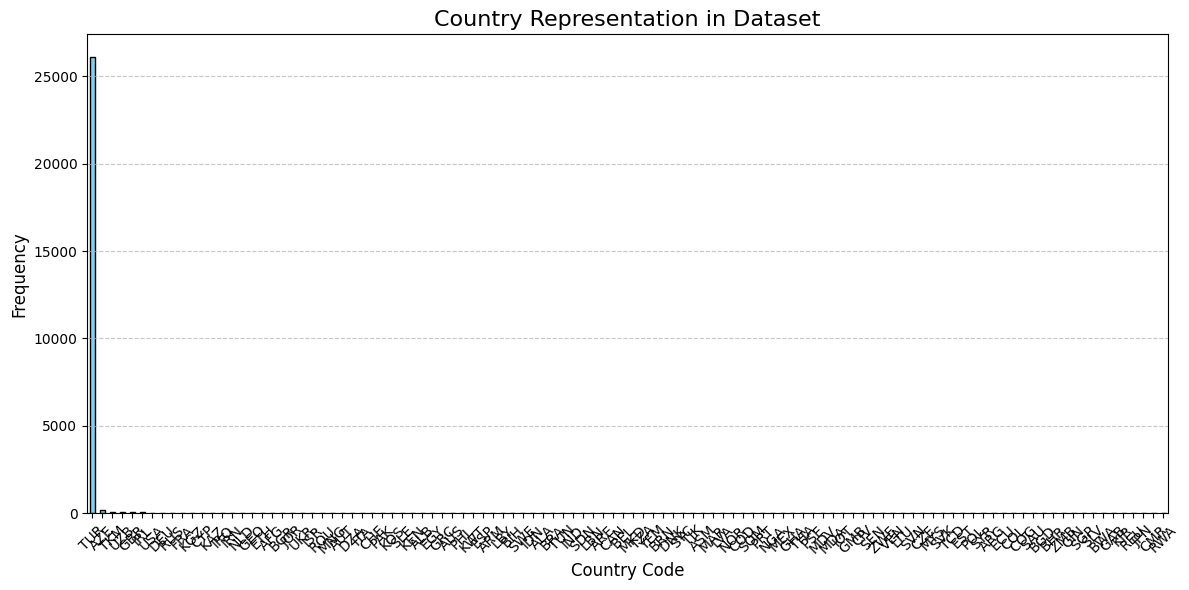

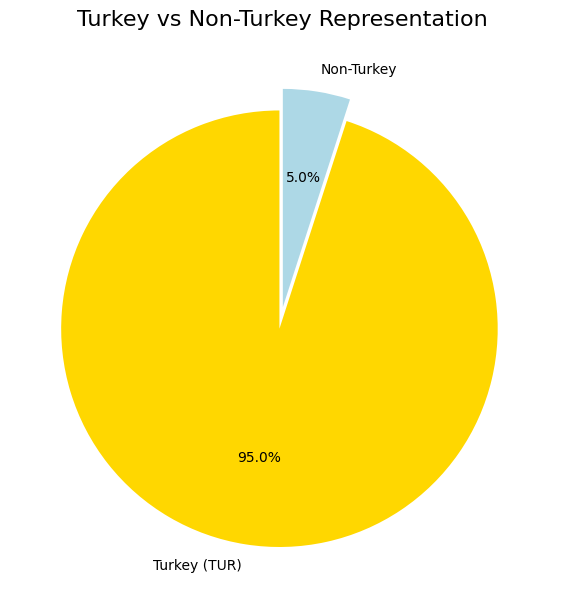

In [95]:

# Summary of country representation
country_counts = all_patients['nationality_country'].value_counts()

# Turkey vs Non-Turkey counts
turkey_count = country_counts.get('TUR', 0)
non_turkey_count = country_counts.sum() - turkey_count

# Print summary
print("Summary of Country Representation:")
print(country_counts)
print(f"\nTurkey (TUR) count: {turkey_count}")
print(f"Non-Turkey count: {non_turkey_count}")

# Visualization of all countries
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Country Representation in Dataset', fontsize=16)
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Turkey vs Non-Turkey pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [turkey_count, non_turkey_count],
    labels=['Turkey (TUR)', 'Non-Turkey'],
    autopct='%1.1f%%',
    colors=['gold', 'lightblue'],
    startangle=90,
    explode=(0.1, 0),  # Slightly explode Turkey for emphasis
)
plt.title('Turkey vs Non-Turkey Representation', fontsize=16)
plt.tight_layout()
plt.show()

#### 3.4. Binary encode "country_nationality" values

In [96]:
# Binary encode the 'nationality_country' column into Turkey (1) vs Non-Turkey (0)
all_patients['is_turkey'] = all_patients['nationality_country'].apply(lambda x: 1 if x == 'TUR' else 0)

# Drop the original 'nationality_country' column (optional)
all_patients.drop('nationality_country', axis=1, inplace=True)

# Verify the transformation
print(all_patients['is_turkey'].value_counts())
print("Turkey vs Non-Turkey binary encoding complete.")

is_turkey
1    26082
0     1366
Name: count, dtype: int64
Turkey vs Non-Turkey binary encoding complete.


### 4. Process and encode the symptom onset date

- **4.1 Convert Date Format**:
  - The `date_of_first_symptoms` column is converted from its original string format (`"DD.MM.YYYY"`) into a standardized `DateTime` format.

- **4.2 Extract the Month**:
  - From the converted `DateTime` column, only the month is extracted into a new column called `symptom_month`.
  - The month is included because COVID-19 may exhibit seasonal patterns. The exact date is excluded as it would likely introduce noise rather than meaningful information.

- **4.3 Handle Missing Month Values**:
  - The number of missing month values is counted before replacement. Only two rows have missing values, which is negligible compared to the dataset size.
  - Missing values are replaced with the default month `"January" (1)`.

- **4.4 One-Hot Encode the Month**:
  - The `symptom_month` column is one-hot encoded:
    - Each month (`1` to `12`) is represented by a separate column.
    - An additional column (`month_nan`) handles any remaining missing or invalid date values.

- **4.5 Remove Redundant Columns**:
  - The original `date_of_first_symptoms` and intermediate `symptom_month` columns are dropped.

This approach ensures that the dataset captures potential seasonal trends while avoiding unnecessary complexity or noise from exact dates.

In [97]:
# Convert the 'date_of_first_symptoms' column to DateTime format
all_patients['date_of_first_symptoms'] = pd.to_datetime(all_patients['date_of_first_symptoms'], format='%d.%m.%Y', errors='coerce')

# Extract the month
all_patients['symptom_month'] = all_patients['date_of_first_symptoms'].dt.month

# Check for rows without a valid month value
missing_month_count = all_patients['symptom_month'].isnull().sum()
print(f"Number of rows with missing month values: {missing_month_count}")

# Reasoning: Only two rows have missing values, which is a negligible amount compared to the dataset size. 
# We replace these with the default month 'January' (1) based on domain-specific knowledge.

# Replace missing month values with January (1)
all_patients['symptom_month'].fillna(1, inplace=True)

# One-hot encode the 'symptom_month' column
symptom_month_encoded = pd.get_dummies(all_patients['symptom_month'], prefix='month', dummy_na=True)

# Add the one-hot encoded columns to the DataFrame
all_patients = pd.concat([all_patients, symptom_month_encoded], axis=1)

# Drop the original 'date_of_first_symptoms' and 'symptom_month' columns
all_patients.drop(['date_of_first_symptoms', 'symptom_month'], axis=1, inplace=True)

# Verify the changes
print("One-hot encoded symptom month columns:")
print(all_patients.filter(like='month_').head())

Number of rows with missing month values: 2
One-hot encoded symptom month columns:
   month_1.0  month_2.0  month_3.0  month_4.0  month_5.0  month_6.0  \
0       True      False      False      False      False      False   
1       True      False      False      False      False      False   
2       True      False      False      False      False      False   
3       True      False      False      False      False      False   
4      False      False      False      False      False      False   

   month_7.0  month_8.0  month_9.0  month_10.0  month_11.0  month_12.0  \
0      False      False      False       False       False       False   
1      False      False      False       False       False       False   
2      False      False      False       False       False       False   
3      False      False      False       False       False       False   
4      False      False      False       False       False        True   

   month_nan  
0      False  
1      False  


/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_15211/1116066204.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_patients['symptom_month'].fillna(1, inplace=True)
